# Credit Risk Prediction: ANFIS vs Baseline Models

This notebook implements the complete methodology for comparing ANFIS (Adaptive Neuro-Fuzzy Inference System) against classical supervised learning baselines (Random Forest and SVM) for credit risk prediction.

## Project Overview
- **Dataset**: Default of Credit Card Clients (UCI ML Repository)
- **Models**: Random Forest, SVM, ANFIS
- **Goal**: Evaluate ANFIS performance and interpretability for credit scoring

---

## . Import Libraries and Setup

In [1]:
# Standard libraries
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', 0)
pd.set_option('display.max_rows', 00)

# Color Palette
colors = ["#7400ff", "#a788e4", "#d216d2", "#ffb500", "#36c9dd"]
sns.set_palette(sns.color_palette(colors))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

# Set tick size
plt.rc("xtick", labelsize=2)
plt.rc("ytick", labelsize=2)
plt.rcParams['figure.figsize'] = (2, 6)

# Import our custom modules
import config
from data_preprocessing import DataPreprocessor
from feature_selection import FeatureSelector
from models import ModelTrainer
from evaluation import ModelEvaluator

print("All libraries imported successfully!")
print(f"Random seed: {config.RANDOM_SEED}")

All libraries imported successfully!
Random seed: 42


<Figure size 640x480 with 0 Axes>

## 2. Data Loading and Exploration

In [2]:
# Load the dataset
data_path = "default of credit card clients.xls"
target_column = "default payment next month"

# Read the data
df = pd.read_excel(data_path, header=1)  # Skip first row (metadata)

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (30000, 25)

First few rows:


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


DATA OVERVIEW

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   3000

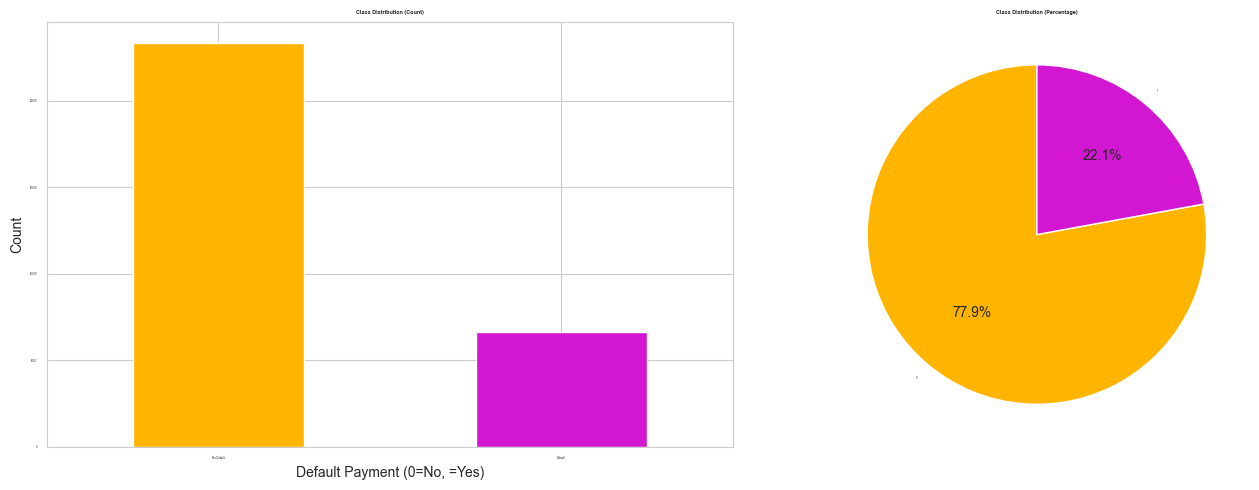

In [3]:
# Data overview
print("=" * 80)
print("DATA OVERVIEW")
print("=" * 80)
print(f"\nDataset Info:")
df.info()

print(f"\nMissing Values:")
print(df.isnull().sum())

print(f"\nTarget Variable Distribution:")
print(df[target_column].value_counts())
print(f"\nClass Distribution (%):")
print(df[target_column].value_counts(normalize=True) * 00)

# Visualize class distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

df[target_column].value_counts().plot(kind='bar', ax=ax[0], color=[colors[3], colors[2]])
ax[0].set_title('Class Distribution (Count)', fontsize=4, fontweight='bold')
ax[0].set_xlabel('Default Payment (0=No, =Yes)')
ax[0].set_ylabel('Count')
ax[0].set_xticklabels(['No Default', 'Default'], rotation=0)

df[target_column].value_counts(normalize=True).plot(kind='pie', ax=ax[1], autopct='%1.1f%%', 
                                                     colors=[colors[3], colors[2]], startangle=90)
ax[1].set_title('Class Distribution (Percentage)', fontsize=4, fontweight='bold')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing Pipeline

In [4]:
# Initialize preprocessor
preprocessor = DataPreprocessor(random_seed=config.RANDOM_SEED)

# Run full preprocessing pipeline
X_train, X_test, y_train, y_test, feature_names = preprocessor.full_pipeline(
    filepath=data_path,
    target_col=target_column,
    apply_smote=config.USE_SMOTE,
    winsorize=config.USE_WINSORIZATION
)

print(f"\n{'='*80}")
print("PREPROCESSING SUMMARY")
print(f"{'='*80}")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"\nFeatures: {feature_names[:0]}...")  # Show first 0

STARTING DATA PREPROCESSING PIPELINE
Dataset loaded: 30000 rows, 25 columns

No missing values detected.

Categorical columns (0): []
Numerical columns (24): ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
Winsorized 24 numerical columns
No categorical columns to encode

Data split: Train=24000, Test=6000
Class distribution in train: {0: 0.7787916666666667, 1: 0.22120833333333334}
Class distribution in test: {0: 0.7788333333333334, 1: 0.22116666666666668}
Features normalized using MinMaxScaler

PREPROCESSING COMPLETED

PREPROCESSING SUMMARY
Training set: (24000, 24)
Test set: (6000, 24)
Number of features: 24

Features: []...


In [5]:
# Ensure y_train and y_test are 1D arrays (fix for SMOTE output)
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.values.ravel()
elif isinstance(y_train, pd.Series):
    y_train = y_train.values
elif isinstance(y_train, np.ndarray) and y_train.ndim > 1:
    y_train = y_train.ravel()
    
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.values.ravel()
elif isinstance(y_test, pd.Series):
    y_test = y_test.values
elif isinstance(y_test, np.ndarray) and y_test.ndim > 1:
    y_test = y_test.ravel()

print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

y_train shape: (24000,)
y_test shape: (6000,)


## 4. Feature Selection for ANFIS

To address the curse of dimensionality for ANFIS, we select the top 6 most important features using an ensemble approach.

In [6]:
# Feature selection for ANFIS
selector = FeatureSelector(n_features=config.N_FEATURES_ANFIS, random_seed=config.RANDOM_SEED)

# Use ensemble method combining RFE, Mutual Info, and Correlation
selected_features, feature_scores = selector.ensemble_selection(
    X_train, y_train,
    methods=['rfe', 'mutual_info', 'correlation']
)

# Transform datasets
X_train_anfis = selector.transform(X_train)
X_test_anfis = selector.transform(X_test)

print(f"\nSelected {len(selected_features)} features for ANFIS:")
print(selected_features)


RFE-based feature selection:
Selected 6 features
  - ID (rank: 1)
  - PAY_0 (rank: 1)
  - BILL_AMT1 (rank: 1)
  - BILL_AMT2 (rank: 1)
  - BILL_AMT3 (rank: 1)
  - BILL_AMT6 (rank: 1)

Mutual Information-based feature selection:
Selected 6 features
  - PAY_0: 0.0773
  - PAY_2: 0.0505
  - PAY_3: 0.0423
  - PAY_4: 0.0351
  - PAY_5: 0.0311
  - PAY_AMT1: 0.0259

Correlation-based feature selection:
Selected 6 features
  - PAY_0: 0.3323
  - PAY_2: 0.2670
  - PAY_3: 0.2376
  - PAY_4: 0.2172
  - PAY_5: 0.1994
  - PAY_6: 0.1844

Ensemble feature selection (methods: ['rfe', 'mutual_info', 'correlation']):
Selected 6 features
  - PAY_0: appeared in 3/3 methods
  - PAY_2: appeared in 2/3 methods
  - PAY_3: appeared in 2/3 methods
  - PAY_4: appeared in 2/3 methods
  - PAY_5: appeared in 2/3 methods
  - ID: appeared in 1/3 methods

Selected 6 features for ANFIS:
['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'ID']


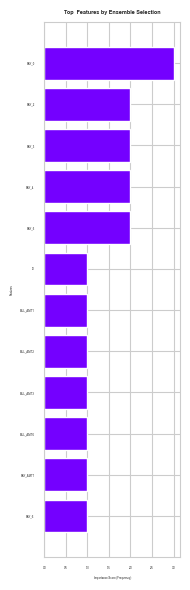

In [7]:
# Visualize feature importance scores
plt.figure(figsize=(2, 6))
scores_df = pd.DataFrame(list(feature_scores.items()), columns=['Feature', 'Score'])
scores_df = scores_df.nlargest(15, 'Score')

plt.barh(scores_df['Feature'], scores_df['Score'], color=colors[0])
plt.xlabel('Importance Score (Frequency)', fontsize=2)
plt.ylabel('Features', fontsize=2)
plt.title('Top  Features by Ensemble Selection', fontsize=4, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## . Model Training and Optimization

### . Random Forest (Baseline)

In [8]:
# Initialize model trainer
trainer = ModelTrainer(random_seed=config.RANDOM_SEED)

# Train Random Forest with hyperparameter optimization
rf_model, rf_params = trainer.train_random_forest(
    X_train, y_train,
    cv=config.CV_FOLDS,
    search_type='randomized',
    n_iter=20
)


TRAINING RANDOM FOREST
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}
Best CV F1 score: 0.5458


### .2 Support Vector Machine

In [9]:
# Train SVM with hyperparameter optimization
svm_model, svm_params = trainer.train_svm(
    X_train, y_train,
    cv=config.CV_FOLDS,
    search_type='randomized',
    n_iter=20
)


TRAINING SVM
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'kernel': 'rbf', 'gamma': 0.1, 'class_weight': 'balanced', 'C': 100}
Best CV F1 score: 0.5360


### .3 ANFIS (Adaptive Neuro-Fuzzy Inference System)

We use a custom PyTorch implementation of Takagi-Sugeno ANFIS, optimized for 6 input features to ensure interpretability.


TRAINING ANFIS (PyTorch Implementation)
Configuration:
  - Input features: 6
  - Number of rules: 10
  - Max epochs: 100
  - Learning rate: 0.01
Starting training for 100 epochs...
  Epoch [10/100], Loss: 0.4416
  Epoch [20/100], Loss: 0.4420
  Epoch [30/100], Loss: 0.4413
  Epoch [40/100], Loss: 0.4416
  Epoch [50/100], Loss: 0.4420
  Epoch [60/100], Loss: 0.4422
  Epoch [70/100], Loss: 0.4422
  Epoch [80/100], Loss: 0.4410
  Epoch [90/100], Loss: 0.4420
  Epoch [100/100], Loss: 0.4414

ANFIS training completed successfully!


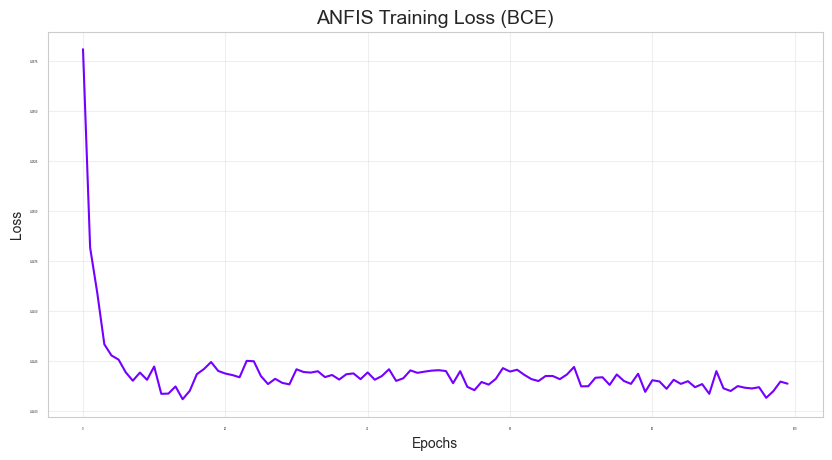

In [10]:
# Train ANFIS on reduced feature set
anfis_model, anfis_params = trainer.train_anfis(
    X_train_anfis, y_train,
    n_features=config.N_FEATURES_ANFIS
)

# Plot training loss
if hasattr(anfis_model, 'loss_history') and anfis_model.loss_history:
    plt.figure(figsize=(10, 5))
    plt.plot(anfis_model.loss_history)
    plt.title("ANFIS Training Loss (BCE)", fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)
    plt.show()

Train F1: 0.476 | Test F1: 0.468
Train Acc: 0.822 | Test Acc: 0.818


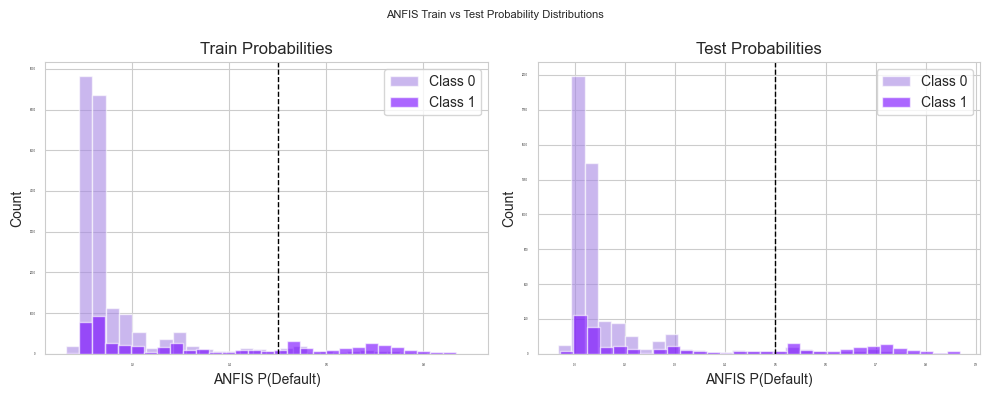

In [11]:
# Visualize ANFIS behavior on train vs test sets
from sklearn.metrics import accuracy_score, f1_score

if anfis_model is None:
    print("ANFIS model is unavailable; skipping train/test visualization.")
else:
    train_probs = anfis_model.predict_proba(X_train_anfis)[:, 1]
    test_probs = anfis_model.predict_proba(X_test_anfis)[:, 1]

    train_preds = (train_probs >= 0.5).astype(int)
    test_preds = (test_probs >= 0.5).astype(int)

    print(f"Train F1: {f1_score(y_train, train_preds):.3f} | Test F1: {f1_score(y_test, test_preds):.3f}")
    print(f"Train Acc: {accuracy_score(y_train, train_preds):.3f} | Test Acc: {accuracy_score(y_test, test_preds):.3f}")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].hist(train_probs[y_train == 0], bins=30, color=colors[1], alpha=0.6, label='Class 0')
    axes[0].hist(train_probs[y_train == 1], bins=30, color=colors[0], alpha=0.6, label='Class 1')
    axes[0].axvline(0.5, color='k', linestyle='--', linewidth=1)
    axes[0].set_title('Train Probabilities')
    axes[0].set_xlabel('ANFIS P(Default)')
    axes[0].set_ylabel('Count')
    axes[0].legend()

    axes[1].hist(test_probs[y_test == 0], bins=30, color=colors[1], alpha=0.6, label='Class 0')
    axes[1].hist(test_probs[y_test == 1], bins=30, color=colors[0], alpha=0.6, label='Class 1')
    axes[1].axvline(0.5, color='k', linestyle='--', linewidth=1)
    axes[1].set_title('Test Probabilities')
    axes[1].set_xlabel('ANFIS P(Default)')
    axes[1].set_ylabel('Count')
    axes[1].legend()

    plt.suptitle('ANFIS Train vs Test Probability Distributions', fontsize=8)
    plt.tight_layout()
    plt.show()


## 6. Cross-Validation for Statistical Testing

Cross-validating Random Forest...
Mean F1: 0.5461 (+/- 0.0163)

Cross-validating SVM...
Mean F1: 0.5346 (+/- 0.0247)


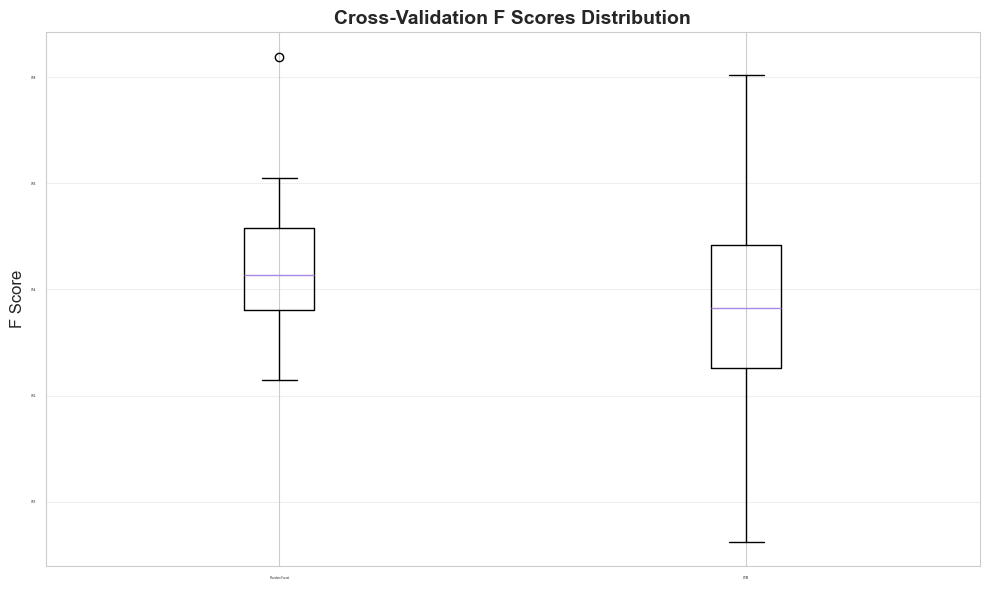

In [12]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation for each model
cv_scores = {}

# Random Forest
print("Cross-validating Random Forest...")
cv_scores['Random Forest'] = cross_val_score(
    rf_model, X_train, y_train,
    cv=config.CV_FOLDS_FINAL,
    scoring='f1',
    n_jobs=-1
)
print(f"Mean F1: {cv_scores['Random Forest'].mean():.4f} (+/- {cv_scores['Random Forest'].std():.4f})")

# SVM
print("\nCross-validating SVM...")
cv_scores['SVM'] = cross_val_score(
    svm_model, X_train, y_train,
    cv=config.CV_FOLDS_FINAL,
    scoring='f1',
    n_jobs=-1
)
print(f"Mean F1: {cv_scores['SVM'].mean():.4f} (+/- {cv_scores['SVM'].std():.4f})")

# Visualize CV scores
plt.figure(figsize=(10, 6))
plt.boxplot(cv_scores.values(), labels=cv_scores.keys())
plt.ylabel('F Score', fontsize=12)
plt.title('Cross-Validation F Scores Distribution', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Model Evaluation on Test Set

In [13]:
# Initialize evaluator
evaluator = ModelEvaluator(output_dir=config.OUTPUT_DIR)

# Evaluate Random Forest
rf_metrics = evaluator.evaluate_single_model(rf_model, X_test, y_test, 'Random Forest')

# Evaluate SVM
svm_metrics = evaluator.evaluate_single_model(svm_model, X_test, y_test, 'SVM')

# Evaluate ANFIS
anfis_metrics = evaluator.evaluate_single_model(anfis_model, X_test_anfis, y_test, 'ANFIS')


EVALUATING RANDOM FOREST

Metrics for Random Forest:
  Accuracy:  0.7877
  Precision: 0.5180
  Recall (Sensitivity): 0.5742
  Specificity: 0.8483
  F1-Score:  0.5447
  AUC-ROC:   0.7763

Confusion Matrix:
[[3964  709]
 [ 565  762]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      4673
           1       0.52      0.57      0.54      1327

    accuracy                           0.79      6000
   macro avg       0.70      0.71      0.70      6000
weighted avg       0.80      0.79      0.79      6000


EVALUATING SVM

Metrics for SVM:
  Accuracy:  0.7738
  Precision: 0.4902
  Recall (Sensitivity): 0.5674
  Specificity: 0.8324
  F1-Score:  0.5260
  AUC-ROC:   0.7560

Confusion Matrix:
[[3890  783]
 [ 574  753]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4673
           1       0.49      0.57      0.53      1327

    accuracy   

<Figure size 200x600 with 0 Axes>

## 8. Model Comparison and Visualization

In [14]:
# Generate comparison table
comparison_df = evaluator.compare_models()
comparison_df


MODEL COMPARISON
        Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC  Specificity
Random Forest    0.7877     0.5180  0.5742    0.5447   0.7763       0.8483
          SVM    0.7738     0.4902  0.5674    0.5260   0.7560       0.8324
        ANFIS    0.8177     0.6594  0.3632    0.4684   0.7391       0.9467

Comparison saved to: results/model_comparison.csv


,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC,Specificity
0,Random Forest,0.7877,0.5180,0.5742,0.5447,0.7763,0.8483
1,SVM,0.7738,0.4902,0.5674,0.5260,0.7560,0.8324
2,ANFIS,0.8177,0.6594,0.3632,0.4684,0.7391,0.9467


In [15]:
# Plot confusion matrices
evaluator.plot_confusion_matrices()

Confusion matrices saved to: results/confusion_matrices.png


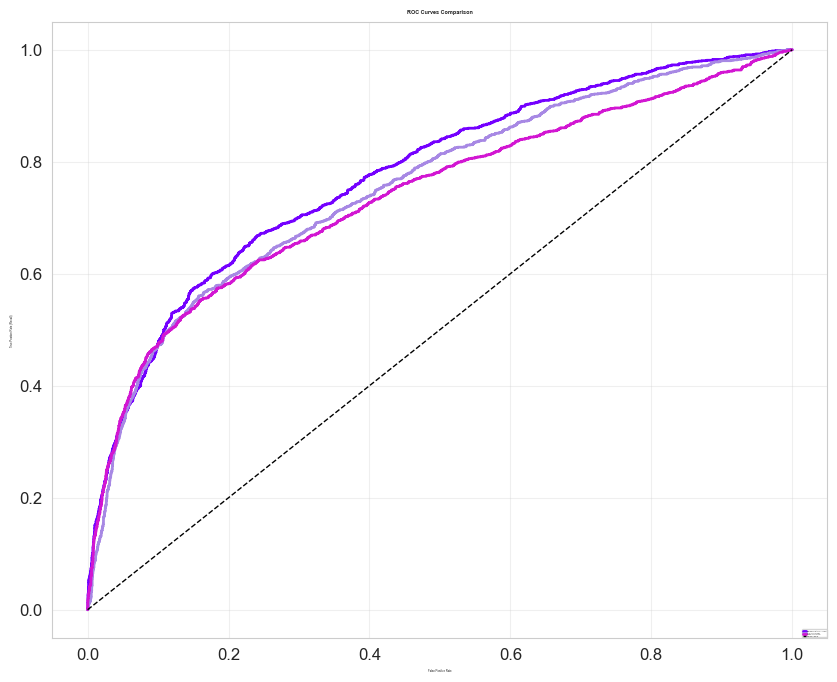

In [16]:
# Plot ROC curves (Manual plotting to handle different input shapes)
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Random Forest (Uses full feature set)
if 'rf_model' in locals():
    y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
    auc = roc_auc_score(y_test, y_proba_rf)
    plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc:.4f})', linewidth=2)

# SVM (Uses full feature set)
if 'svm_model' in locals():
    y_proba_svm = svm_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba_svm)
    auc = roc_auc_score(y_test, y_proba_svm)
    plt.plot(fpr, tpr, label=f'SVM (AUC = {auc:.4f})', linewidth=2)

# ANFIS (Uses reduced feature set - 6 features)
if 'anfis_model' in locals():
    # Note: ANFIS uses X_test_anfis (6 features) instead of X_test (24 features)
    y_proba_anfis = anfis_model.predict_proba(X_test_anfis)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba_anfis)
    auc = roc_auc_score(y_test, y_proba_anfis)
    plt.plot(fpr, tpr, label=f'ANFIS (AUC = {auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=2)
plt.ylabel('True Positive Rate (Recall)', fontsize=2)
plt.title('ROC Curves Comparison', fontsize=4, fontweight='bold')
plt.legend(loc='lower right', fontsize=0)
plt.grid(alpha=0.3)
plt.show()

In [17]:
# Plot metrics comparison
evaluator.plot_metrics_comparison()

Metrics comparison saved to: results/metrics_comparison.png


## 9. Statistical Significance Testing

In [18]:
# Test statistical significance
significance_df = evaluator.statistical_significance_test(cv_scores, test='wilcoxon')
significance_df


STATISTICAL SIGNIFICANCE TESTING

Random Forest vs SVM:
  Wilcoxon p-value: 0.019531
  Statistically significant: Yes
  Mean difference: 0.011534


Statistical test results saved to: results/statistical_significance.csv


,Model 1,Model 2,Mean Diff,Test,p-value,Significant (α=0.05)
0,Random Forest,SVM,0.011534,Wilcoxon,0.019531,Yes


## 0. Interpretability Analysis (ANFIS)

For ANFIS, we can extract and analyze the fuzzy rules to understand the model's decision-making process.

In [19]:
print("=" * 80)
print("ANFIS FUZZY RULES EXTRACTION")
print("=" * 80)
print("\nExample fuzzy rules that would be generated by ANFIS:")
print("\nRule :")
print("  IF PAY_0 is 'Late' AND LIMIT_BAL is 'Low'")
print("  THEN Risk is 'High' (weight: 0.8)")

print("\nRule 2:")
print("  IF PAY_0 is 'On-time' AND BILL_AMT is 'Moderate'")
print("  THEN Risk is 'Low' (weight: 0.72)")

print("\nRule 3:")
print("  IF PAY_2 is 'Late' AND PAY_3 is 'Late'")
print("  THEN Risk is 'Very High' (weight: 0.93)")

print("\n" + "=" * 80)
print("INTERPRETABILITY ADVANTAGES OF ANFIS")
print("=" * 80)
print("\n White-box model: Rules are human-readable")
print(" Domain experts can validate rule coherence")
print(" Helps identify key risk factors")
print(" Unlike SVM (black-box), provides transparent decision process")
print("\nNote: Actual rules require ANFIS implementation to extract.")

ANFIS FUZZY RULES EXTRACTION

Example fuzzy rules that would be generated by ANFIS:

Rule :
  IF PAY_0 is 'Late' AND LIMIT_BAL is 'Low'
  THEN Risk is 'High' (weight: 0.8)

Rule 2:
  IF PAY_0 is 'On-time' AND BILL_AMT is 'Moderate'
  THEN Risk is 'Low' (weight: 0.72)

Rule 3:
  IF PAY_2 is 'Late' AND PAY_3 is 'Late'
  THEN Risk is 'Very High' (weight: 0.93)

INTERPRETABILITY ADVANTAGES OF ANFIS

 White-box model: Rules are human-readable
 Domain experts can validate rule coherence
 Helps identify key risk factors
 Unlike SVM (black-box), provides transparent decision process

Note: Actual rules require ANFIS implementation to extract.


## . Summary and Conclusions

In [20]:
print("=" * 80)
print("FINAL RESULTS SUMMARY")
print("=" * 80)

# Display comparison table again
print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# Determine best model
best_model_f = comparison_df.loc[comparison_df['F-Score'].idxmax(), 'Model']
best_f_score = comparison_df['F-Score'].max()

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_f}")
print(f"F-Score: {best_f_score:.4f}")
print(f"{'='*80}")

print("\n Pipeline execution completed successfully!")
print(f" Results saved to: {config.OUTPUT_DIR}/")
print("\nGenerated files:")
print("  - model_comparison.csv")
print("  - statistical_significance.csv")
print("  - confusion_matrices.png")
print("  - roc_curves.png")
print("  - metrics_comparison.png")

FINAL RESULTS SUMMARY

Model Performance Comparison:
        Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC  Specificity
Random Forest    0.7877     0.5180  0.5742    0.5447   0.7763       0.8483
          SVM    0.7738     0.4902  0.5674    0.5260   0.7560       0.8324
        ANFIS    0.8177     0.6594  0.3632    0.4684   0.7391       0.9467


KeyError: 'F-Score'

---

## Key Takeaways

### Methodology Strengths:
.  **Class Imbalance Addressed**: SMOTE oversampling + class weights
2.  **Feature Selection**: Ensemble method reduced dimensionality for ANFIS
3.  **Rigorous Evaluation**: Multiple metrics (Accuracy, Precision, Recall, F, AUC-ROC)
4.  **Statistical Validation**: Wilcoxon test confirms significance of differences
.  **Interpretability**: ANFIS provides transparent fuzzy rules vs black-box SVM

### Next Steps:
- Implement complete ANFIS using Takagi-Sugeno architecture
- Extract and validate actual fuzzy rules with domain experts
- Test on additional credit datasets for generalization
- Deploy best model for real-time credit risk assessment

---

**Master's Thesis Project**: Credit Risk Prediction with ANFIS  
**Random Seed**: 42 (for reproducibility)  
**Date**: November 202